In [1]:
import torch
import numpy as np
import pandas as pd
import librosa as lr
import matplotlib.pyplot as plt

from librosa import display as lrd
import IPython.display as ipd

from torch.utils.data import DataLoader, ConcatDataset, random_split
from asteroid.data import TimitDataset
from tqdm import tqdm

from asteroid.data.utils import find_audio_files

%load_ext autoreload
%autoreload 2

In [2]:
def show_wav(wav, sr=16000):
    if type(wav) == str:
        wav, sr = lr.load(wav)
    elif type(wav) == torch.Tensor:
        wav = wav.detach().numpy()
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    lrd.waveplot(wav, sr=sr, ax=axes[0])
    
    S_db = lr.amplitude_to_db(np.abs(lr.stft(wav)))
    img = lrd.specshow(S_db, sr=sr, ax=axes[1])
    fig.colorbar(img, ax=axes[1])
    
    fig.tight_layout()
    plt.show()
    ipd.display(ipd.Audio(wav, rate=sr))

In [3]:
TIMIT_CACHE_DIR = '/import/vision-eddydata/dm005_tmp/mixed_wavs_asteroid'

In [4]:
test_snrs = [-30, -25, -20, -15, -10, -5, 0]
test_sets = {}

i = 0
for snr in tqdm(test_snrs, 'Load datasets'):
    test_sets[snr] = TimitDataset(
        '../../../datasets/TIMIT', '../../../datasets/noises-test-drones',
        cache_dir=TIMIT_CACHE_DIR, snr=snr, dset_name='test-drones',
        subset='test', random_seed=68 + i, with_path=True)
    i += 1

Load datasets: 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]


In [5]:
from torch import optim
from pytorch_lightning import Trainer, loggers as pl_loggers
from asteroid_filterbanks.transforms import mag
from asteroid.engine import System, UNetGAN

from asteroid import DCUNet, DCCRNet
from asteroid.losses import singlesrc_neg_sisdr

In [6]:
model1_conf = torch.load('dcunet_16_v2.pt')
model1 = DCUNet.from_pretrained(model1_conf)

In [7]:
model2_conf = torch.load('dccrn_v2.pt')
model2 = DCCRNet.from_pretrained(model2_conf)

In [8]:
model3_conf = torch.load('dcunet_20_onecycle_v3.pt')
model3 = DCUNet.from_pretrained(model3_conf)

In [19]:
unetgan = UNetGAN.load_from_checkpoint('logs/lightning_logs/version_7/checkpoints/epoch=101-step=397528.ckpt')

In [10]:
mix, clean, path = test_sets[-15][0]

In [11]:
print(path)

/import/vision-eddydata/dm005_tmp/mixed_wavs_asteroid/-15db/TEST/DR4/MGMM0/SX139.WAV.n122.wav


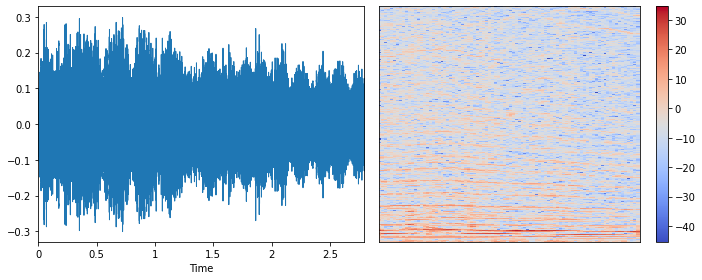

In [12]:
show_wav(mix)

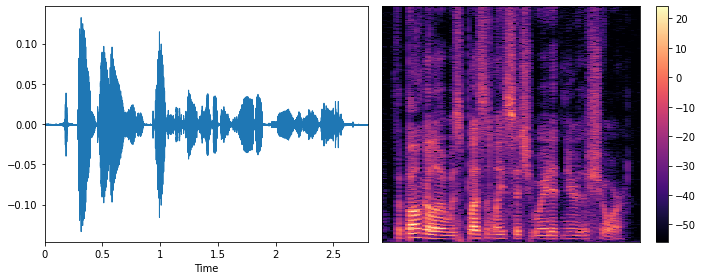

In [15]:
show_wav(clean)

In [14]:
enh = model3(mix).flatten()

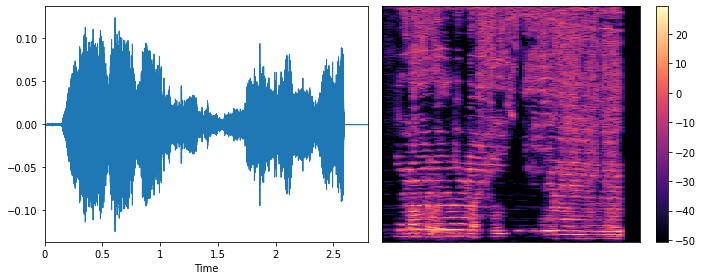

In [16]:
show_wav(enh)

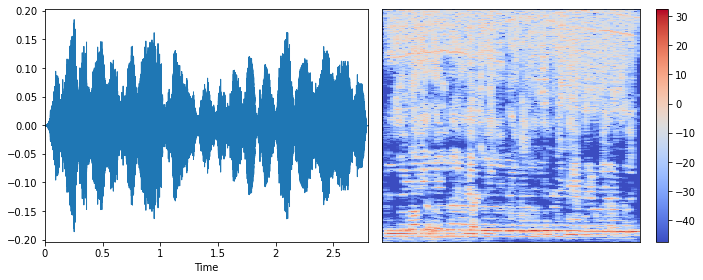

In [17]:
enh2 = model2(mix).flatten()
show_wav(enh2)

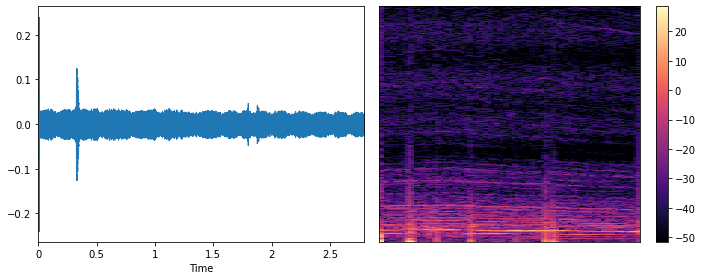

In [20]:
enh_gan = unetgan(mix).flatten()
show_wav(enh_gan)

In [18]:
from pathlib import PurePath
import soundfile as sf
import os

In [19]:
def enhance_test(model, test_sets, model_name):
    model = model.cuda()
    
    for snr, test_set in test_sets.items():
        print(f'SNR: {snr}db')
        common_folder = PurePath(f'/import/vision-eddydata/dm005_tmp/mixed_wavs_asteroid/{snr}db/TEST')
        enh_folder = PurePath(f'/import/vision-eddydata/dm005_tmp/enh_wavs/test/{model_name}/{snr}db')
        loader = DataLoader(test_set, num_workers=10)

        for mix, clean, path in tqdm(loader, 'Enhancing audio'):
            mix = mix.cuda()
            enh = model(mix).detach().flatten().cpu().numpy()
            rel_path = PurePath(path[0]).relative_to(common_folder)
            out_path = (enh_folder / rel_path).with_suffix('.enh.wav')
            os.makedirs(out_path.parent, exist_ok=True)
            sf.write(file=str(out_path), data=enh, samplerate=16000)

In [20]:
#enhance_test(model1, test_sets, "dcunet-16-v2")

In [21]:
#enhance_test(model2, test_sets, "dccrn-v2")

In [25]:
enhance_test(model3, test_sets, "dcunet-20-drones-v3")

Enhancing audio:   0%|          | 0/3360 [00:00<?, ?it/s]

SNR: -30db


Enhancing audio:   0%|          | 0/3360 [00:00<?, ?it/s]

SNR: -25db


Enhancing audio:   0%|          | 0/3360 [00:00<?, ?it/s]

SNR: -20db


Exception ignored in: <function _releaseLock at 0x7f78b029b430>
Traceback (most recent call last):
  File "/homes/dm005/conda_env/lib/python3.8/logging/__init__.py", line 223, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Enhancing audio:   0%|          | 0/3360 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [26]:
enhance_test(unetgan, test_sets, "unetgan-v1")

Enhancing audio:   0%|          | 0/3360 [00:00<?, ?it/s]

SNR: -30db


Enhancing audio:   0%|          | 0/3360 [00:00<?, ?it/s]

SNR: -25db


Enhancing audio:   0%|          | 0/3360 [00:00<?, ?it/s]

SNR: -20db


Enhancing audio:   0%|          | 0/3360 [00:00<?, ?it/s]

SNR: -15db


Enhancing audio:   0%|          | 0/3360 [00:00<?, ?it/s]

SNR: -10db


Enhancing audio:   0%|          | 0/3360 [00:00<?, ?it/s]

SNR: -5db


Enhancing audio:   0%|          | 0/3360 [00:00<?, ?it/s]

SNR: 0db


Enhancing audio: 100%|██████████| 3360/3360 [00:50<00:00, 66.94it/s]
